In [1]:
# general imports
import sys
sys.path.append("/home/ismini/FastEMRIWaveforms")
sys.path.append("/home/ismini/FastEMRIWaveforms/EMRI_FrequencyDomainWaveforms-main/")
print(sys.path)

import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mpmath

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils import *


['/home/ismini/FastEMRIWaveforms/acer_work', '/home/ismini/anaconda3/envs/few_env/lib/python310.zip', '/home/ismini/anaconda3/envs/few_env/lib/python3.10', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/lib-dynload', '', '/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages', '/home/ismini/FastEMRIWaveforms', '/home/ismini/FastEMRIWaveforms/EMRI_FrequencyDomainWaveforms-main/']


In [2]:
# additional imports
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

from mpmath import *
from scipy.integrate import DOP853
import scipy

# import HaloFeedback (version with additional dLdt evaluation)
#from HaloFeedbackdLdt_ecc import DistributionFunction, PowerLawSpike, PlateauSpike
from Final_HaloFeedback import DistributionFunction, PowerLawSpike

#from fastinterp import *

import time
import warnings
from abc import ABC, abstractmethod
from time import time as timeit

import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import quad, simps
from scipy.interpolate import interp1d
from scipy.special import ellipeinc, ellipkinc, ellipe, ellipk, betainc
from scipy.special import gamma as Gamma
from scipy.special import beta as Beta

import pandas as pd 

In [3]:
# settings for the elliptic integrals
mp.dps = 25
mp.pretty = True

# settings for the waveform
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # 0 (1) we (don't) want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
#from few.utils.utility import omp_set_num_threads
#omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

In [4]:
# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

### Gravitational Wave losses

In [5]:
def Edot_GW(p,e):
    # Azimuthal frequency
    Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

    # Post-Newtonian calculations
    yPN = pow(Omega_phi,2./3.)

    EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
    LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)
    return EdotPN, LdotPN


### Circular vs Eccentric Dynamical Friction losses

In [6]:
# this just verifies the elliptic DF losses for e=0 match the circular and the circular without considering any changes in the density

def Edot_DF_circ(p_init, e_init, p, e, M, mu, gamma_evol, rho_sp, r_sp, Lambda=-1):
    p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

    DMS = PowerLawSpike(p_init, e_init, p, e, M, mu, gamma_evol, rho_sp, Lambda=-1)

    r_apo = DMS.r_apo(p, e)
    # rho_apo = DMS.rho(p_pc)
    # rho_apo_init = DMS.rho_init(p_pc)

    Edot_DF_circ = DMS.dEdt_DF(r_apo) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    Edot_DF_circ_new = DMS.dEdt_circular(p, e) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)

    # dEdt_DF_ecc_evol feeds with p in pc 
    Edot_DF_ecc = DMS.dEdt_DF_ecc_evol(p_pc, e, gamma_evol, rho_sp, r_sp) * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
    Ldot_DF_ecc = DMS.dLdt_DF_ecc_evol(p_pc, e, gamma_evol, rho_sp, r_sp) * 10**6 /Power(C_SI,2)

    return Edot_DF_circ, Edot_DF_circ_new, Edot_DF_ecc, Ldot_DF_ecc


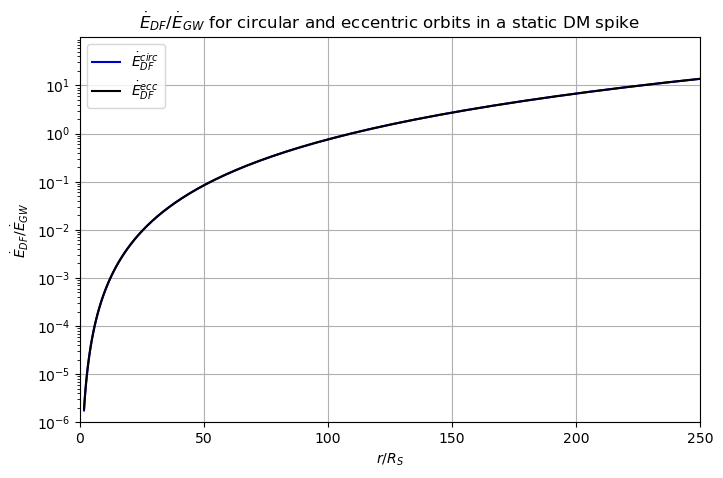

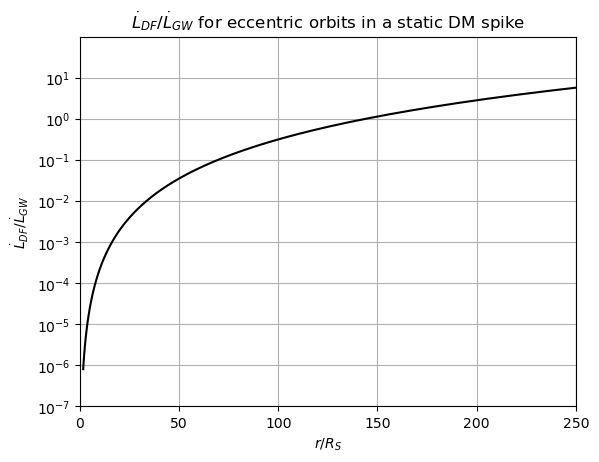

In [7]:
# Testing the losses for eccentric spike vs circular spike without feedback
ptest = 10**np.linspace(1, 4, 100)
M = 1e5 # M_sun
mu = 1e1 # M_sun
rho_sp = 226 # M_sun pc^-3
gamma_sp = 7/3
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


Edot_circ = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[0]/Edot_GW(pp,0.0)[0] for pp in ptest])
Edot_circ_new = np.asarray([Edot_DF_circ(pp, 0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[1]/Edot_GW(pp, 0.0)[0] for pp in ptest])
Edot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[2]/Edot_GW(pp,0.0)[0] for pp in ptest])
Ldot_ecc = np.asarray([Edot_DF_circ(pp,0.0, pp, 0.0, M, mu, gamma_sp, rho_sp, r_sp=r_sp)[3]/Edot_GW(pp,0.0)[1] for pp in ptest])

plt.figure(figsize=(8,5))
plt.title('$\dot{E}_{DF}/\dot{E}_{GW}$ for circular and eccentric orbits in a static DM spike')
plt.semilogy(ptest/6, Edot_circ, label='$\dot{E}_{DF}^{circ}$' , color = 'mediumblue')
#plt.semilogy(ptest/6, Edot_circ_new, color='r')
plt.semilogy(ptest/6, Edot_ecc, label='$\dot{E}_{DF}^{ecc}$' , color='k')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-6), 100])
plt.yticks([10**i for i in range(-6, 2)])
plt.legend()
plt.show()

plt.figure()
plt.title('$\dot{L}_{DF}/\dot{L}_{GW}$ for eccentric orbits in a static DM spike')
plt.semilogy(ptest/6, Ldot_ecc, color = 'k')
plt.ylabel('$\dot{L}_{DF}/\dot{L}_{GW}$')
plt.xlabel('$r/R_S$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-7), 100])
plt.yticks([10**i for i in range(-7, 2)])
plt.show()


This confirms the validity of eccentric losses in the circular case (i.e.  $e=0$)

### Dynamical Friction losses
This way we can obtain the DF losses for eccentric orbits in a static DM spike witout using HaloFeedback.

In [8]:
def dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp):
        """Rate of change of energy due to DF (km/s)^2 s^-1 M_sun.
        Use to find the energy losses from one set of (p,e, gamma) to the next.

        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - r_sp: constant normalization radius [pc]
        """
        pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dEdt = (1 / pc_to_km) * (2*(1 - e**2)**(3/2) * G_N**(3/2) * mu**2 * rho_sp * r_sp**(gamma) * CoulombLog)/(np.sqrt(M) * p_pc**(gamma -1/2))

        def integrand_E(theta):

            #return dEdt * (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)
            return (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / np.sqrt(1 + 2 * e * np.cos(theta) + e**2)    
        
        result_E, error_E = quad(integrand_E, 0.0, 2 * np.pi)
        E_dot_DF = dEdt * result_E * 10**6 /(Power(C_SI,2) * MTSUN_SI * M)
    
        

        return (E_dot_DF)

def dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp):
        """Rate of change of angular momentum in [(km/s)^2 M_sun].
        Use to find the angular momentum losses from one set of (p,e, gamma) to the next.
    
        Parameters:
            - p: semi-latus rectum, in [pc]
            - e: eccentricity [dim/les]
            - gamma: DM spike index [dim/les]
            - rho_sp: constant normalization factor [M_sun/pc^3]
            - r_sp: constant normalization radius [pc]
        """
        # pc_to_km = 3.08567758149137e13
        G_N = 4.3021937e-3 # (km/s)^2 pc M_sun^-1
        c = 2.99792458e5  # km/s
        p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        CoulombLog = np.log(np.sqrt(M/mu))

        # xi = (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p**3)))

        dLdt = (2 * (1 - e**2)**(3/2) * G_N * mu**2 * rho_sp * r_sp**(gamma) * CoulombLog)/(M* p_pc**(gamma -2))

        def integrand_L(theta):

            return (1 + ((G_N * M)*(1 + 2 * e * np.cos(theta) + e**2) / (c**2 * p_pc)) - ((G_N * M)**2 * (1 + 2 * e * np.cos(theta) + e**2)**2 / (c**4 * p_pc**2)) - ((G_N * M)**3 * (1 + 2 * e * np.cos(theta) + e**2)**3 / (c**6 * p_pc**3))) * (1 + e * np.cos(theta))**(gamma-2) / (1 + 2 * e * np.cos(theta) + e**2)**(3/2)
    
        result_L, error_L = quad(integrand_L, 0.0, 2 * np.pi)
        L_dot_DF = dLdt * result_L * 10**6 /Power(C_SI,2)

        return (L_dot_DF)


### Trajectory module for static spikes and eccentric orbits

In [9]:
# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class DF:
    def __init__(self, epsilon, M, mu, gamma, rho_sp, r_sp):
        self.epsilon = epsilon
        self.M = M
        self.mu = mu
        self.rho_sp = rho_sp
        self.r_sp = r_sp
        self.gamma = gamma


    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon
        M = self.M
        mu = self.mu
        rho_sp = self.rho_sp
        r_sp = self.r_sp
        gamma = self.gamma
        
        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y

        # guard against bad integration steps
        if e >= 1.0 or p < 6.0 or (p - 6 - 2* e) < 0.05:
#             print('bad', y)
            return [0.0, 0.0, 0.0, 0.0]
        if e<1e-5:
            e = 1e-5

        # Azimuthal frequency
        # perform elliptic calculations
        Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

        # GW
        EdotPN,LdotPN = Edot_GW(p,e)

        # dynamical friction parameters
        EdotDF = dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)
        LdotDF = dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)

        # flux
#         print(EdotDF/EdotPN)
        Edot = -epsilon*(EdotPN + EdotDF )
        Ldot = -epsilon*(LdotPN + LdotDF )
        
        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = Omega_r;
        
        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]
            
        if e<=1e-5:
            dydt[1] = 0.0

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class DFTrajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, T=1.0, dt=10.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M

        M = M
        mu = mu
        gamma_sp = args[0]
        rho_sp = args[1]
        r_sp = args[2]
        
        rhs = DF(epsilon, M, mu, gamma_sp, rho_sp, r_sp)
        #print(rhs)

        # the tolerance is important!
        integrator = DOP853(rhs, 0.0, y0, T,  rtol=1e-10, atol=1e-10, first_step=dt/Msec)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:

            integrator.step()
            
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)
           
            if (p - 6 -2*e) < 0.05:
                run = False


        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    

static_traj = DFTrajectory()

### No spike from the static spike trajectory

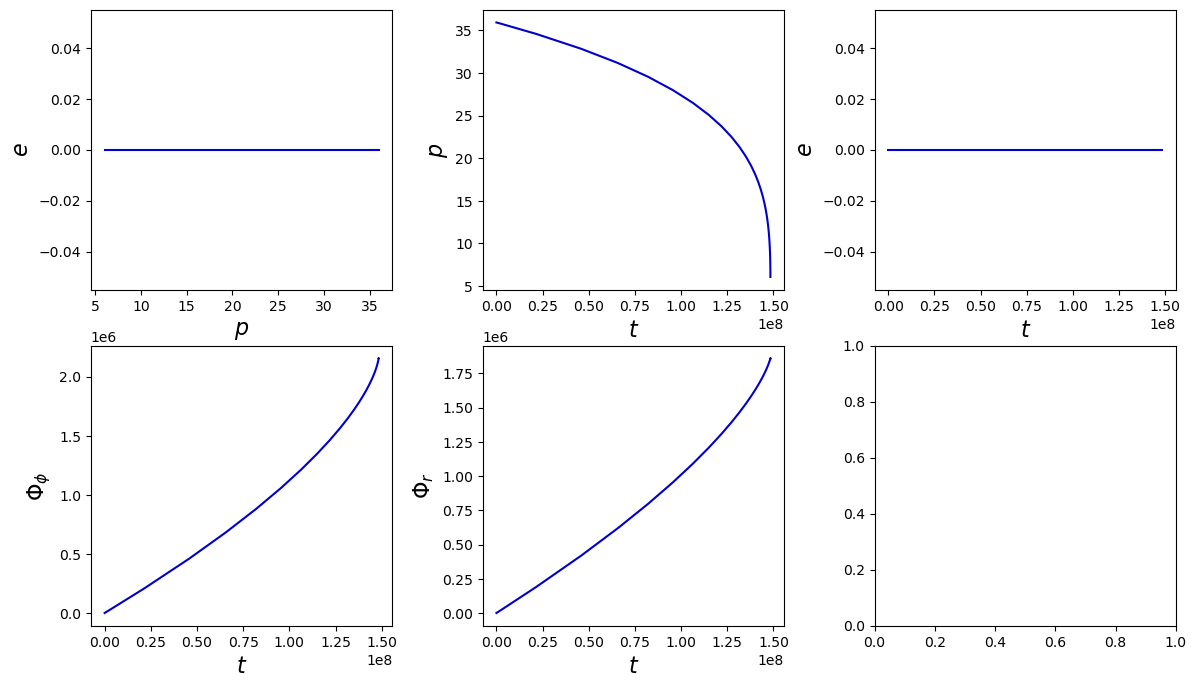

In [10]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

no_static_spike_traj = static_traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t_no_st_sp, p_no_st_sp, e_no_st_sp, x_no_st_sp, Phi_phi_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp = no_static_spike_traj
# spline the results
no_static_spike_spline = CubicSplineInterpolant(t_no_st_sp, np.stack((p_no_st_sp, e_no_st_sp, x_no_st_sp, Phi_phi_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_no_st_sp, p_no_st_sp, e_no_st_sp, Phi_theta_no_st_sp, Phi_r_no_st_sp]
xs = [p_no_st_sp, t_no_st_sp, t_no_st_sp, t_no_st_sp, t_no_st_sp]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='mediumblue')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

### Static spike trajectory

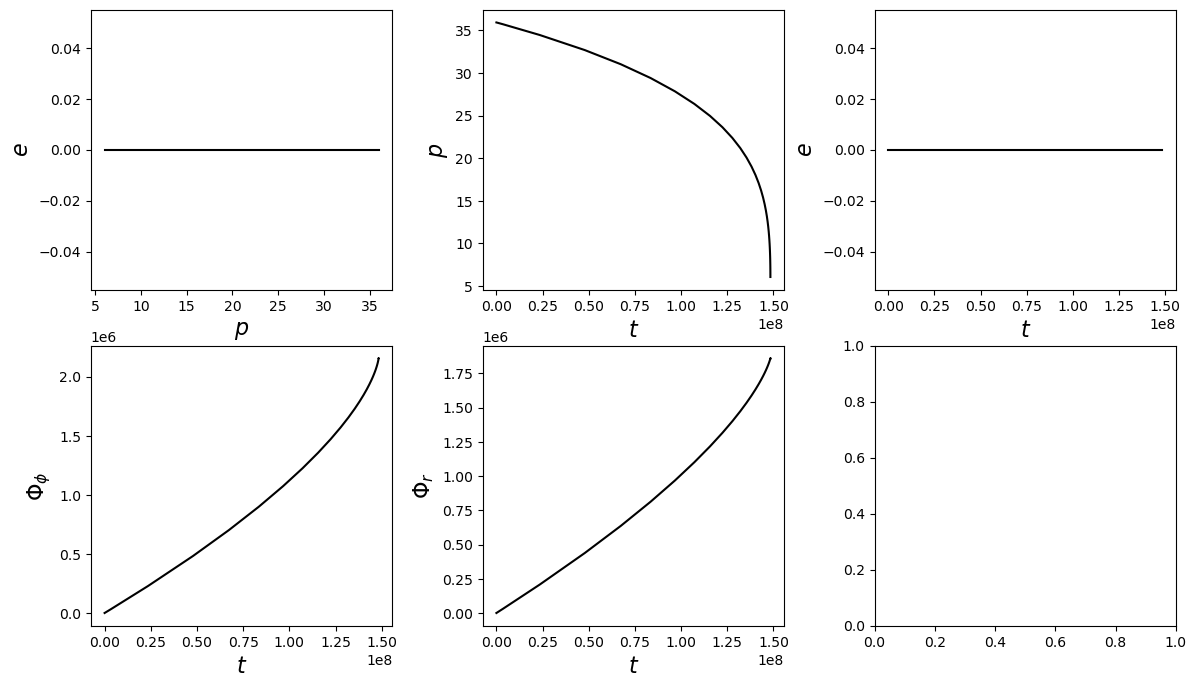

In [11]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

static_spike_traj = static_traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t_st_sp, p_st_sp, e_st_sp, x_st_sp, Phi_phi_st_sp, Phi_theta_st_sp, Phi_r_st_sp = static_spike_traj
# spline the results
static_spike_spline = CubicSplineInterpolant(t_st_sp, np.stack((p_st_sp, e_st_sp, x_st_sp, Phi_phi_st_sp, Phi_theta_st_sp, Phi_r_st_sp)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_st_sp, p_st_sp, e_st_sp, Phi_theta_st_sp, Phi_r_st_sp]
xs = [p_st_sp, t_st_sp, t_st_sp, t_st_sp, t_st_sp]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'p')

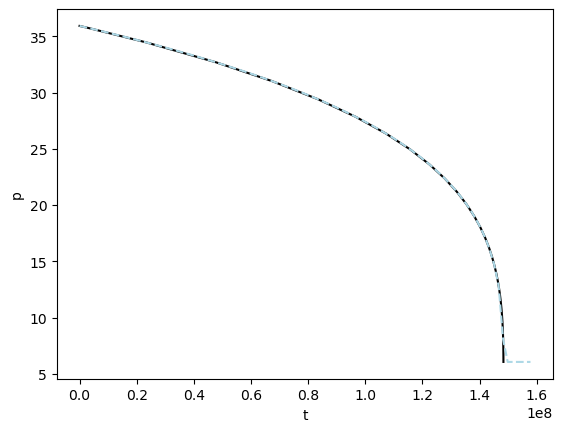

In [12]:
plt.plot(t_st_sp, p_st_sp, color='k')
newt = np.linspace(0.0, T*YRSID_SI,num=100)

plt.plot(newt, static_spike_spline(newt)[0],'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, 'Number of cycles')

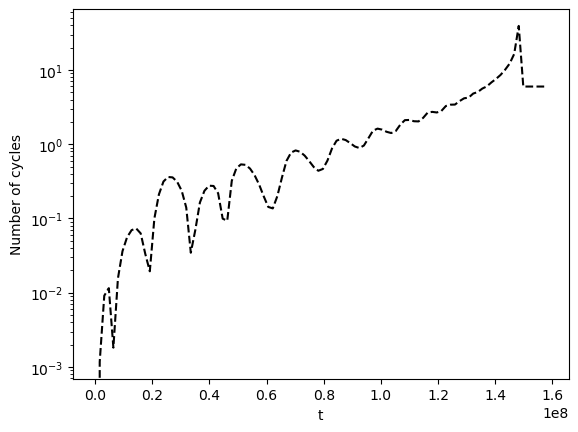

In [13]:
plt.figure()
# the time is store in the spline
plt.semilogy(newt, np.abs(no_static_spike_spline(newt)[4]-static_spike_spline(newt)[4])/(2*np.pi),'--', color='k')
plt.xlabel('t')
plt.ylabel('Number of cycles')
# should be similar to fig 5 https://arxiv.org/pdf/2211.01362.pdf

To get the deppasing as a function of frequency.

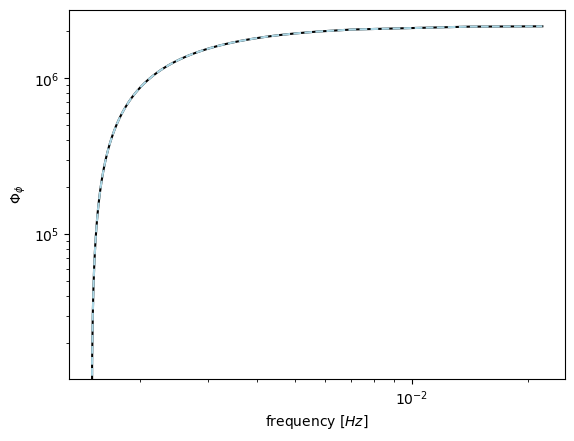

/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages/few/summation/interpolatedmodesum.py:217: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  warnings.warn(


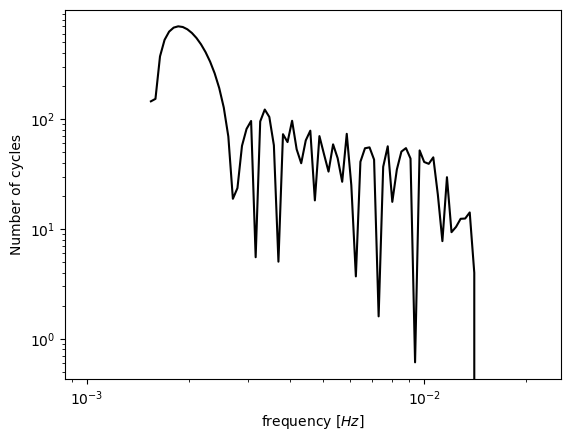

In [14]:
# no spike
no_stat_sp_ff = no_static_spike_spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
no_stat_sp_phase = no_static_spike_spline(newt)[4]
no_stat_sp_spl_phase = CubicSplineInterpolant(no_stat_sp_ff, no_stat_sp_phase)
# spike
ff_stat_sp = static_spike_spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase_stat_sp = static_spike_spline(newt)[4]
stat_sp_spl_phase = CubicSplineInterpolant(ff_stat_sp, phase_stat_sp)

freq = 10**np.linspace(-3,np.log10(np.max(no_stat_sp_ff)),num=100)

plt.figure()
# the time is store in the spline
plt.loglog(no_stat_sp_ff, no_stat_sp_phase, color='k')
plt.loglog(ff_stat_sp, phase_stat_sp,'--', color='lightblue')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\phi}$')
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(no_stat_sp_spl_phase(freq)-stat_sp_spl_phase(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

### Evoliving the spike
Here we make use of the HaloFeedback to evolve the DM denstity between each step $(p,e)$ of the integrator.

In [57]:
def spike_evolution(p0, e0, t0, p, e, t, M, mu, rho_sp, r_sp, gamma_init, DMS = None):
    # you can use p,e as variables
    # not sure if (I probably must) I need to use p0, e0 as variables
    # use functions of ecc_rel_HaloFeedback.py as DMS.
    # following EvolutionPlot.py
    # make sure to use functions of ecc_rel_HaloFeedback.py

    # unit conversions
    pc_to_km = 3.08567758149137e13

    SPEED_CUT = True

    if DMS is None:
        DMS = PowerLawSpike(p0, e0, p, e, M=M, mu=mu, gamma=gamma_init, rho_sp=rho_sp, Lambda=-1)

    #r0_apo = p0_pc/(1 - e0) # initial apocenter in pc
    r0_apo = DMS.r_apo(p0, e0)
    #v0_ecc_apo = np.sqrt((G_N * M)/(p0_pc)) * (1 - e0) # initial velocity of the CO in km/s
    v0_ecc_apo = DMS.v_ecc_apo(p0, e0)

    v_cut = -1 # to use functions of ecc_rel_HaloFeedback
    if SPEED_CUT:
        v_cut = v0_ecc_apo

    #r_apo = p_pc/(1 - e) # apocenter in pc
    r_apo = DMS.r_apo(p, e) # apocenter in pc
    #r_peri = p_pc/(1 + e) # pericenter in pc
    r_peri = DMS.r_peric(p, e) # pericenter in pc
    
    #v_ecc_apo = np.sqrt((G_N * M)/(p_pc)) * (1 - e) # velocity of the CO in km/s
    v_ecc_apo = DMS.v_ecc_apo(p, e)
    v_ecc_peri = DMS.v_ecc_peri(p, e)

    T_orb = 2 * np.pi * r0_apo * pc_to_km / v0_ecc_apo # orbital time in sec
    
    N_orb = int((t - t0)/T_orb) # Number of orbits within (|p_i - p_i+1|, |e_i - e_i+1|) to evolve
    if N_orb >= 10000:
        orbits_per_step = 500
    elif N_orb >= 1000 and N_orb < 10000:
        orbits_per_step = 100
    elif N_orb >= 100 and N_orb < 1000:
        orbits_per_step = 10
    else:
        orbits_per_step = 1
        
    N_step = int(N_orb / orbits_per_step)

    if N_step <= 1:
        N_step = 2 

    # we don't need many steps, EMRI cycles are aprox. 10^4 - 10^5
    # the CO will pass many times from the same radii

    dt = T_orb * orbits_per_step # in sec
    t_list = dt * N_step * np.linspace(0, 1, N_step + 1)

    print('Number of orbits = ', N_orb)
    print('Total time [days] = ', N_step*dt/(3600*24))

    # radial grid for calculating the density
    # check that r0_apo and r_peri are updated for each (p,e)
    # update them in the integrator of the trajectory module, where this function is also going to be used
    N_r = 100 
    r_list = np.linspace(r0_apo, r_peri, N_r - 1)
    r_list = np.sort(np.append(r_list, r_apo))

    rho_list = np.zeros((N_step + 1, N_r))

    # extract the index of r_peri 
    # (that is where we will get the updated density 
    # and feed it to dEdt_DF_ecc) 
    r_apo_ind = np.where(r_list == r_apo)[0][0]

    M_dm_list = np.zeros(N_step-1)
    M_dm_list[0] = DMS.TotalMass()

    # using the proper dEdtDF
    DF_list = np.zeros(N_step)
    DF_list[0] = DMS.dEdt_DF(r0_apo, v_cut)

    E_list = np.zeros(N_step)
    E_list[0] = DMS.TotalEnergy()

    E_ej_tot = 0.0 * t_list

    if SPEED_CUT: 
        rho_init = np.array([DMS.rho(r, v_ecc_apo) for r in r_list])
        
    rho_list[0, :] = rho_init

    for i in range(N_step):
        if SPEED_CUT:
             rho_list[i, :] = np.array([DMS.rho(r, v0_ecc_apo) for r in r_list])

        M_dm_list[i-1] = DMS.TotalMass()

        E_ej_tot[i] = E_ej_tot[i-1] + DMS.dEdt_ej(v_orb=v0_ecc_apo, v_cut=v_cut) * dt

        df1 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += df1
        df2 = DMS.delta_f(r0_apo, v_orb=v0_ecc_apo, dt=dt, v_cut=v_cut)
        DMS.f_eps += 0.5 * (df2 - df1)

        E_list[i] = DMS.TotalEnergy()

        DF_list[i] = DMS.dEdt_DF(r0_apo, v_cut)

    r_apo = r_list[r_apo_ind]
    rho_apo_init = rho_list[0, r_apo_ind]
    print('rho_apo_init = ', rho_apo_init)
    rho_apo_evol = rho_list[-2, r_apo_ind]
    print('rho_apo_evol = ', rho_apo_evol)
    drho = np.abs(rho_apo_init-rho_apo_evol)

    gamma_temp = (np.log((r_sp/r_apo)**gamma_init - (drho/rho_sp))) / (np.log(r_sp/r_apo))
    dgamma = ((drho / (rho_sp * gamma_init)) * (r_sp / r_apo)**(1 - gamma_init))
    
    gamma_evol = np.log(rho_apo_evol/rho_sp) / np.log(r_sp/r_apo)
    if gamma_evol <= 1:
        gamma_evol = 1.00000001

    # gamma_evol = gamma_init / gamma_temp
    # gamma_evol = dgamma / np.abs(gamma_init - gamma_temp)
    print('gamma_evol', gamma_evol)

    # gamma_evol = (np.log((r_sp/r_apo)**gamma_init - (drho/rho_sp))) / (np.log(r_sp/r_apo))
    # gamma_evol = gamma_init - np.log((1 + (drho / rho_apo_evol)) / (r_sp/r_apo))
    # gamma_evol = np.log(rho_apo_evol/rho_apo_init) / np.log(r_sp/r_apo) + gamma_init

    rho_apo_gamma_evol = rho_sp * (r_sp / r_apo)**gamma_evol
    print('rho_apo_gamma_evol = ', rho_apo_gamma_evol)

    return gamma_evol

### This is the actual trajectory class that can be used to produce GWs of EMRIs embedded in dynamic spikes.

In [58]:
# trying to plot the energy and angular momentum losses from the trajectory 
# maybe different in the sense that it cannot be used to produce waveforms.
# maybe put an if before the return of DFTrajectory to select if you wanna use for GWs or not.
# as in first use for the spike, get plots and then use for GWs
# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class DF_evol:
    def __init__(self, epsilon, M, mu, rho_sp, r_sp):
        self.epsilon = epsilon
        self.M = M
        self.mu = mu
        self.rho_sp = rho_sp
        self.r_sp = r_sp

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon
        M = self.M
        mu = self.mu
        rho_sp = self.rho_sp
        r_sp = self.r_sp
        
        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        gamma = self.gamma_evol

        # guard against bad integration steps
        if e >= 1.0 or p < 6.0 or (p - 6 - 2* e) < 0.05:
#             print('bad', y)
            return [0.0, 0.0, 0.0, 0.0]
        if e<1e-5:
            e = 1e-5

        # Azimuthal frequency
        # perform elliptic calculations
        Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

        # GW
        EdotPN, LdotPN = Edot_GW(p,e)

        # dynamical friction parameters
        EdotDF = dEdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)
        LdotDF = dLdt_DF_ecc(M, mu, p, e, gamma, rho_sp, r_sp)

        # flux
        Edot = -epsilon*(EdotPN + EdotDF)
        Ldot = -epsilon*(LdotPN + LdotDF)
        
        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = Omega_r;
        
        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]
            
        if e<=1e-5:
            dydt[1] = 0.0

        return dydt


# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class DF_evol_Trajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, Phi_phi=np.pi, T=1.0, dt=10.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        Msec = M * MTSUN_SI

        epsilon = mu/M

        M = M
        mu = mu
        rho_sp = args[1]
        r_sp = args[2]
        p_init = p0
        e_init = e0
        t_init = 0
        gamma_init = args[0]


        rhs = DF_evol(epsilon, M, mu, rho_sp, r_sp)
        rhs.gamma_evol = gamma_init

        # the tolerance is important!
        integrator = DOP853(rhs, 0.0, y0, T, rtol=1e-12, atol=1e-12, first_step=dt/Msec)


        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:

            integrator.step()
            
            p, e, Phi_phi, Phi_r = integrator.y

            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            t = integrator.t * Msec
            gamma_evol = spike_evolution(p_init, e_init, t_init, p, e, t, M, mu, rho_sp, r_sp, gamma_init, DMS=None)
            # print(t - t_init)
            p_init = p
            e_init = e
            t_init = t
            gamma_init = gamma_evol

            if (p - 6 -2*e) < 0.05:
                run = False


        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        print(p_out)
 
        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    

traj = DF_evol_Trajectory()

p0[pc] =  1.7196507147966344e-07
Number of orbits =  0
Total time [days] =  0.015429862416974359


rho_apo_init =  6.926715495441847e+18
rho_apo_evol =  6.926709268944853e+18
gamma_evol 2.3005032814772672
rho_apo_gamma_evol =  6.92670926894482e+18
Number of orbits =  0
Total time [days] =  0.01542986203704689
rho_apo_init =  3.9623337000620314e+18
rho_apo_evol =  3.9623301489357266e+18
gamma_evol 2.266654346912934
rho_apo_gamma_evol =  3.9623301489357425e+18
Number of orbits =  0
Total time [days] =  0.015429860748876301
rho_apo_init =  2.2231599662610557e+18
rho_apo_evol =  2.2231579804810248e+18
gamma_evol 2.2316327054542278
rho_apo_gamma_evol =  2.2231579804810232e+18
Number of orbits =  0
Total time [days] =  0.01542985702020183
rho_apo_init =  1.2202823188779569e+18
rho_apo_evol =  1.2202812329520307e+18
gamma_evol 2.195281212450782
rho_apo_gamma_evol =  1.22028123295203e+18
Number of orbits =  1
Total time [days] =  0.01542984730028387
rho_apo_init =  6.535166414175076e+17
rho_apo_evol =  6.535160622607643e+17
gamma_evol 2.1574374730116594
rho_apo_gamma_evol =  6.5351606226076

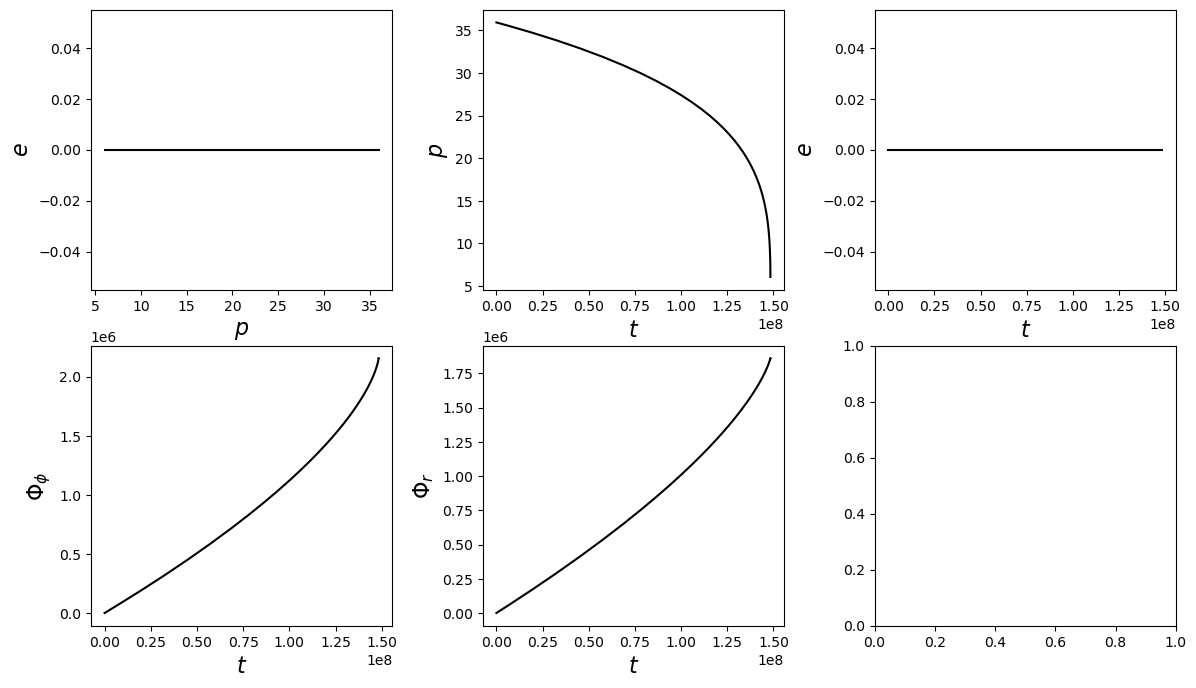

In [59]:
# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun
p0 = 35.93515813204665
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

dynamic_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t_s, p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s = dynamic_spike_traj
# spline the results
spline_s = CubicSplineInterpolant(t_s, np.stack((p_s, e_s, x_s, Phi_phi_s, Phi_theta_s, Phi_r_s)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e_s, p_s, e_s, Phi_phi_s, Phi_r_s]
xs = [p_s, t_s, t_s, t_s, t_s]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Number of orbits =  0
Total time [days] =  0.015429862416974359
rho_apo_init =  0.0001229508103259724
rho_apo_evol =  0.00012295035272643078
gamma_evol 2.327502707237497
rho_apo_gamma_evol =  0.00012295035272642942
Number of orbits =  0
Total time [days] =  0.015429862037061655
rho_apo_init =  7.040921106724548e-05
rho_apo_evol =  7.040894941801469e-05
gamma_evol 2.3216384697746975
rho_apo_gamma_evol =  7.040894941801303e-05
Number of orbits =  0
Total time [days] =  0.015429860744882307
rho_apo_init =  4.018881486369217e-05
rho_apo_evol =  4.018866574776009e-05
gamma_evol 2.315739776720592
rho_apo_gamma_evol =  4.0188665747759664e-05
Number of orbits =  0
Total time [days] =  0.01542985669320636
rho_apo_init =  2.286250253883988e-05
rho_apo_evol =  2.2862417842542222e-05
gamma_evol 2.3098057814754434
rho_apo_gamma_evol =  2.2862417842542205e-05
Number of orbits =  1
Total time [days] =  0.015429846194454524
rho_apo_init =  1.2961356648647384e-05
rho_apo_evol =  1.2961308707782126e-05


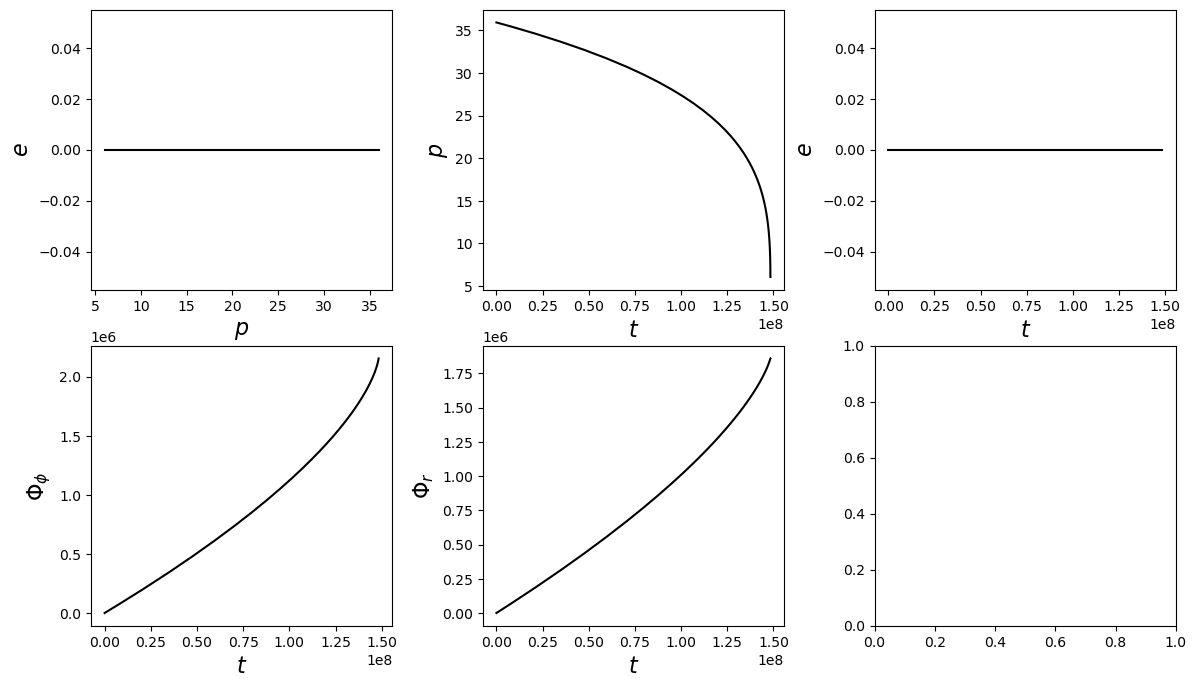

In [60]:
# testing the trajectory
M = 1e5
mu = 1e1
p0 = 35.93515813204665
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
initial_f = 3e-3
initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
#print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

no_spike_traj = traj(M, mu, 0.0, p0, e0, 1.0, gamma_sp, rho_sp, r_sp, T=T, dt=10.0)
t, p, e, x, Phi_phi, Phi_theta, Phi_r = no_spike_traj
# spline the results
spline = CubicSplineInterpolant(t, np.stack((p, e, x, Phi_phi, Phi_theta, Phi_r)) )

# plot
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r]
xs = [p, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, color='k')
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

Text(0, 0.5, 'p')

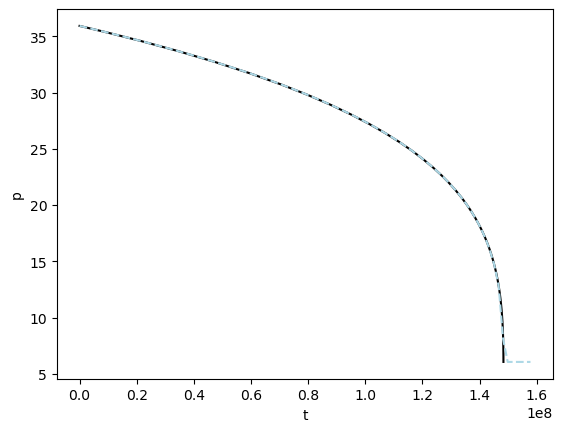

In [61]:
plt.plot(t, p, color='k')
#newt = np.linspace(0.0, T*YRSID_SI,num=100)

plt.plot(newt, spline(newt)[0],'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('p')

Text(0, 0.5, '$p$ $[pc]$')

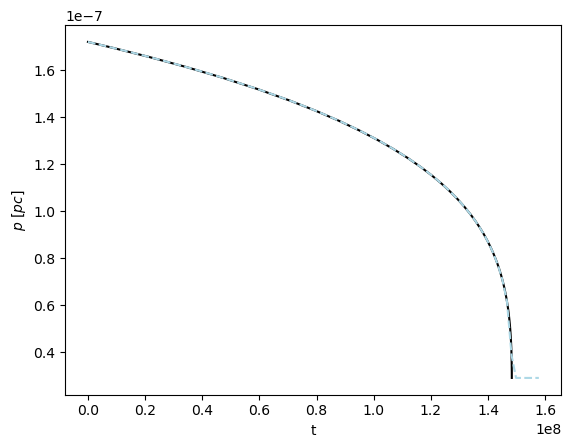

In [62]:
p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
plt.plot(t, p_pc, color='k')
#newt = np.linspace(0.0, T*YRSID_SI,num=100)
sp_p_pc = (spline(newt)[0]*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

plt.plot(newt, sp_p_pc,'--', color='lightblue')
plt.xlabel('t')
plt.ylabel('$p$ $[pc]$')

Text(0, 0.5, 'Number of cucles')

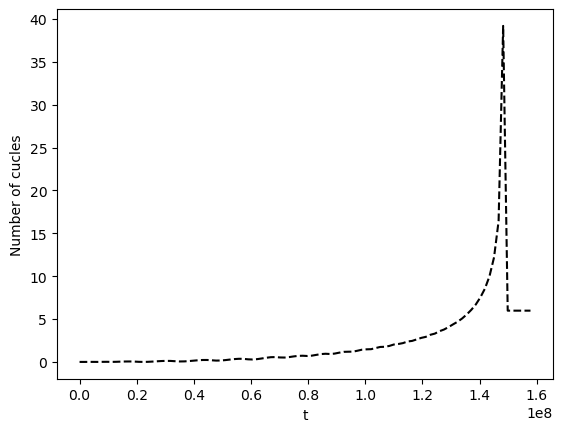

In [63]:
plt.figure()
# the time is store in the spline
plt.plot(newt, np.abs(spline(newt)[4]-spline_s(newt)[4])/(2*np.pi),'--', color='k')
plt.xlabel('t')
plt.ylabel('Number of cucles')
# should be fig 5 https://arxiv.org/pdf/2211.01362.pdf

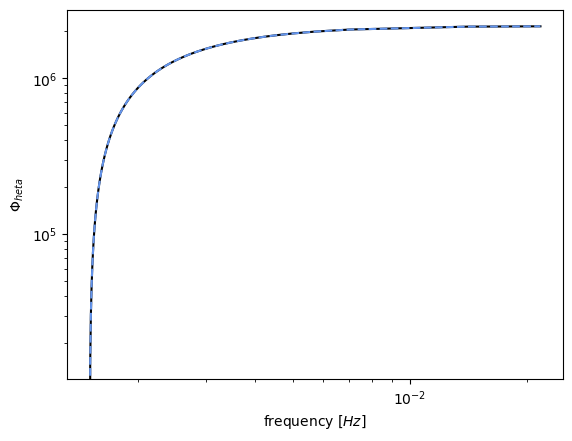

/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages/few/summation/interpolatedmodesum.py:217: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  warnings.warn(


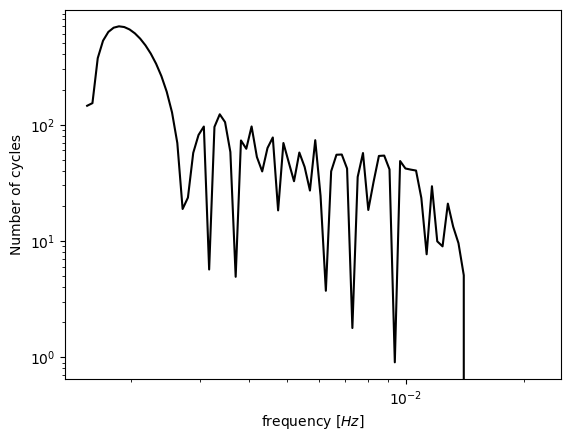

In [64]:
# omega = p**(-3/2)
# no spike
ff = spline(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase = spline(newt)[4]
spl_phase = CubicSplineInterpolant(ff, phase)
# spike
ff_sp = spline_s(newt)[0]**(-3/2) / (2*np.pi*M*MTSUN_SI)
phase_sp = spline_s(newt)[4]
spl_phase_sp = CubicSplineInterpolant(ff_sp, phase_sp)

freq = 10**np.linspace(-3,np.log10(np.max(ff)),num=100)

plt.figure()
# the time is store in the spline
plt.loglog(ff, phase, color ='k')
plt.loglog(ff_sp, phase_sp,'--', color='cornflowerblue')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(spl_phase(freq)-spl_phase_sp(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

The last plot of the following 3 shows the difference between the evolving and the static spike. The number of cycles is reduced by $\sim 10$, showing the importance of feedback from the DM spike on the expected dephasing.

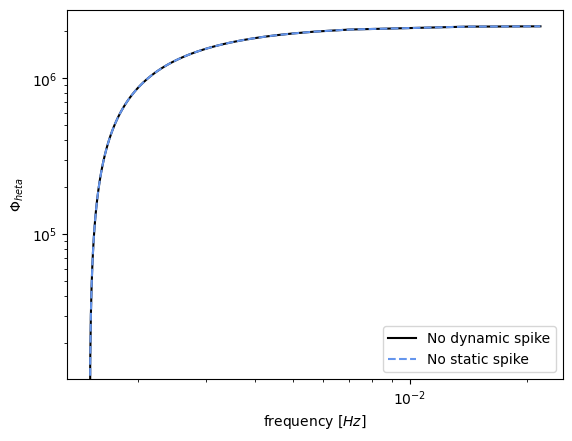

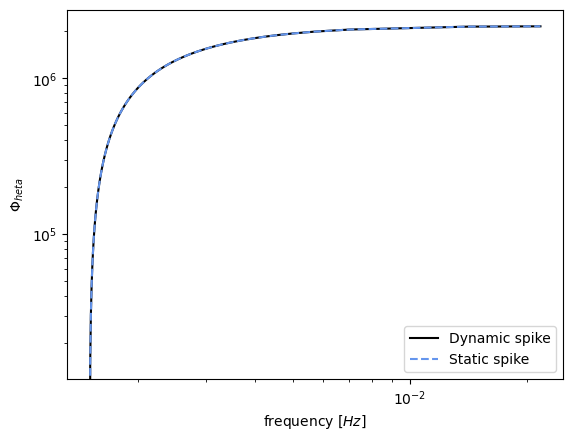

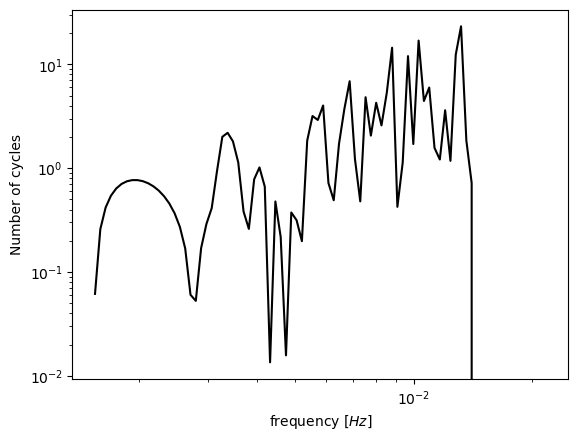

In [65]:
# No spike 
plt.figure()
# the time is stored in the spline
plt.loglog(ff, phase, color ='k', label='No dynamic spike')
plt.loglog(no_stat_sp_ff, no_stat_sp_phase, '--', color='cornflowerblue', label='No static spike')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.legend()
plt.show()

# Dynamic vs Static spike
plt.figure()
# the time is stored in the spline
plt.loglog(ff_sp, phase_sp, color='k', label='Dynamic spike')
plt.loglog(ff_stat_sp, phase_stat_sp,'--', color='cornflowerblue', label='Static spike')
# plt.loglog(ff, np.abs(spl_phase(ff)-spl_phase_sp(ff))/(np.pi*2) )
# plt.loglog(ff_sp, np.abs(phase-phase_sp)/(np.pi*2) )
plt.xlabel('frequency $[Hz]$')
plt.ylabel('$\Phi_{\theta}$')
plt.legend()
plt.show()

plt.figure()
# by reversing the frequency I obtain something similar to fig 5
plt.loglog(freq[::-1], np.abs(stat_sp_spl_phase(freq)-spl_phase_sp(freq)), color='k')
plt.xlabel('frequency $[Hz]$')
plt.ylabel('Number of cycles')
plt.show()

### Ploting the energy and angular momentum losses.

In [66]:
class Evolution:
    def __init__(self, rho_sp, r_sp):
        self.rho_sp = rho_sp
        self.r_sp = r_sp

    def __call__(self, p_init, e_init, t_init, p, e, t, gamma_init, M, mu):

        rho_sp = self.rho_sp
        r_sp = self.r_sp

        #p_pc = (p*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
        #p_init_pc = (p_init*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI

        # spike_evolution feeds with dimensionless p
        sp_evol = spike_evolution(p_init, e_init, t_init, p, e, t, M, mu, rho_sp, r_sp, gamma_init, DMS=None)
        gamma_evol = sp_evol

        # dEdt_DF_ecc_evol feeds with p in pc 
        EdotDF = dEdt_DF_ecc(M, mu, p, e, gamma_evol, rho_sp, r_sp)
        LdotDF = dLdt_DF_ecc(M, mu, p, e, gamma_evol, rho_sp, r_sp)

        ELdot_DF = [EdotDF, LdotDF]

        return ELdot_DF, gamma_evol
    

In [67]:
def Edot_GW(p,e):
    # Azimuthal frequency
    Omega_phi, _, Omega_r = get_fundamental_frequencies(0.0, p, e, 1.0)

    # Post-Newtonian calculations
    yPN = pow(Omega_phi,2./3.)

    EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
    LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)
    return EdotPN, LdotPN

[3162.27766017 2983.64724028 2815.10727745 2656.08778295 2506.05096553
 2364.48941265 2230.92437441 2104.90414451 1986.00253259 1873.81742286
 1767.96941424 1668.1005372  1573.87304316 1484.96826225 1401.0855256
 1321.94114847 1247.26747089 1176.81195243 1110.33631817 1047.61575279
  988.43814035  932.60334688  879.92254357  830.21756813  783.32032231
  739.07220335  697.32356765  657.93322466  620.76795936  585.70208181
  552.61700199  521.4008288   491.94799164  464.15888336  437.93952341
  413.20124001  389.86037025  367.83797718  347.05958282  327.45491629
  308.95767617  291.50530628  275.03878409  259.50242114  244.84367468
  231.01297001  217.96353278  205.65123083  194.03442496  183.07382803
  172.73237219  162.97508346  153.76896347  145.08287785  136.88745095
  129.1549665   121.85927385  114.97569954  108.48096388  102.35310219
   96.57139053   91.11627561   85.96930867   81.11308308   76.53117547
   72.20809018   68.12920691   64.28073117   60.64964775   57.22367659
   53.9

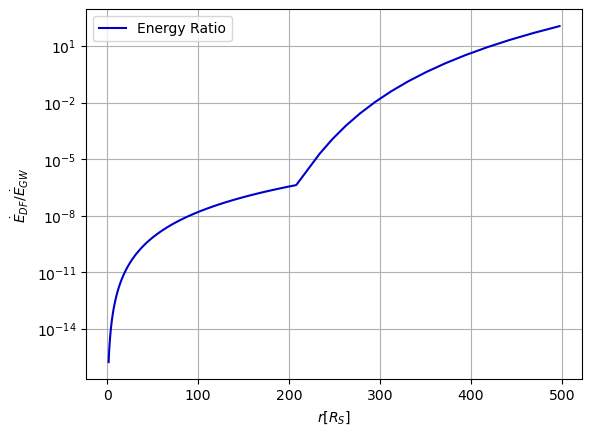

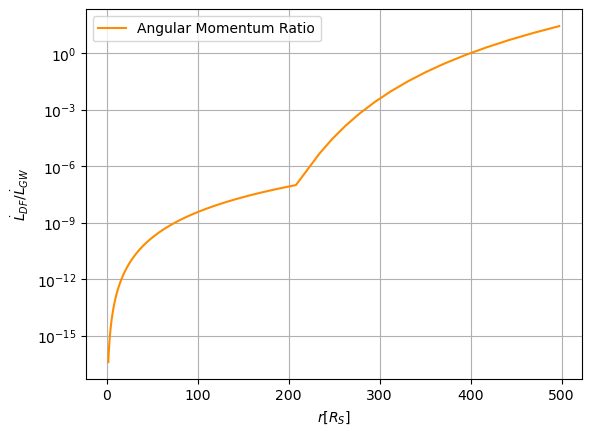

In [68]:

# Testing the DF losses for one simplistic trajectory (p,t)[N_p], e = 0 
N_p = 100
p_init_create = 10**np.linspace(1, 3.5, N_p)
p_init = np.flip(p_init_create)
p_evol = np.roll(p_init, shift=-1)
p_evol[-1] = p_evol[-2] - 0.00001
print(p_init, p_evol)

e_init = 0.0
e = 0.0

M = 1e5 # M_sun
mu = 1e1 # M_sun
epsilon = mu/M
gamma_init = 7/3
rho_sp = 226 # M_sun/pc^3
r_sp = (((3-gamma_init)* 0.2**(3-gamma_init) * M)/(2 * np.pi * rho_sp))**(1/3) # pc
print('r_sp = ', r_sp)

# Initialize T
T = 5.0 * 365.25 * 24 * 3600  # 5 years in seconds

# Initialize t_init with T and create t_evol accordingly
t_init = np.array([T])  # Start with T

for i in range(1, N_p):
    dt = (p_init[i] - p_evol[i]) / p_evol[i]
    t_init = np.append(t_init, t_init[-1] - dt*t_init[-1])

# Reverse the arrays to have them in increasing order
t_init = np.flip(t_init)
t_evol = np.roll(t_init, shift=-1)
t_evol[-1] = t_evol[-2]  # Set the last element as the second-to-last

# Now, you have t_init and t_evol arrays as specified
print("t_init:", t_init)
print("t_evol:", t_evol)


evol = Evolution(rho_sp, r_sp)

#ELdot_DF_list = []
Edot_DF_list = []
Ldot_DF_list = []

#ELdot_GW_list = []
Edot_GW_list = []
Ldot_GW_list = []

gamma_evol_list = []


for i, p_in in enumerate(p_init):
    # Use p_init[i] for each iteration
    p_evol_i = p_evol[i]
    t_init_i = t_init[i]
    t_evol_i = t_evol[i]
    ELdot_DF, gamma_evol = evol(p_in, e_init, t_init_i, p_evol_i, e, t_evol_i, gamma_init, M, mu)
    #ELdot_DF_list.append(ELdot_DF)
    Edot_DF = ELdot_DF[0]
    Ldot_DF = ELdot_DF[1]
    Edot_DF_list.append(Edot_DF)
    Ldot_DF_list.append(Ldot_DF)
    #print(np.shape(ELdot_DF_list), ELdot_DF_list)
    gamma_init = gamma_evol
    gamma_evol_list.append(gamma_init)
    #ELdot_GW = Edot_GW(p_evol_i, e)
    E_dot_GW = Edot_GW(p_evol_i, e)[0]
    Ldot_GW = Edot_GW(p_evol_i, e)[1]
    #ELdot_GW_list.append(ELdot_GW)
    Edot_GW_list.append(E_dot_GW)
    Ldot_GW_list.append(Ldot_GW)

#print(np.shape(ELdot_DF_list), ELdot_DF_list)
print(np.shape(Edot_DF_list), Edot_DF_list)
print(np.shape(Ldot_DF_list), Ldot_DF_list)

#print(np.shape(ELdot_GW_list), ELdot_GW_list)
print(np.shape(Edot_GW_list), Edot_GW_list)
print(np.shape(Ldot_GW_list), Ldot_GW_list)

# ELdot_DF_list is a list of arrays, convert it to a numpy array
Edot_DF_array = np.array(Edot_DF_list)
Ldot_DF_array = np.array(Ldot_DF_list)
Edot_GW_array = np.array(Edot_GW_list)
Ldot_GW_array = np.array(Ldot_GW_list)

# ELdot_DF_array has shape (N_p, 2)
print(np.shape(Edot_DF_array), Edot_DF_array)
print(np.shape(Ldot_DF_array), Ldot_DF_array)
print(np.shape(Edot_GW_array), Edot_GW_array)
print(np.shape(Ldot_GW_array), Ldot_GW_array)
print(np.shape(gamma_evol_list), gamma_evol_list)

# Calculate Eratio and Lratio
Eratio = Edot_DF_array / Edot_GW_array
Lratio = Ldot_DF_array / Ldot_GW_array

# Stack Eratio and Lratio horizontally to create a (N_p, 2) array
ratios = np.column_stack((Eratio, Lratio))

print(np.shape(ratios), ratios)


plt.figure()
plt.semilogy(p_evol/6, Eratio, label='Energy Ratio', color='mediumblue')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
#plt.xlim([0, 250])
#plt.ylim([10**(-5), 100])
#plt.yticks([10**i for i in range(-7, 2)])
plt.legend()
plt.show()

plt.figure()
plt.semilogy(p_evol/6, Lratio, label='Angular Momentum Ratio', color='darkorange')
plt.ylabel('$\dot{L}_{DF}/\dot{L}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
#plt.xlim([0, 250])
#plt.ylim([10**(-5), 100])
#plt.yticks([10**i for i in range(-7, 2)])
plt.legend()
plt.show()



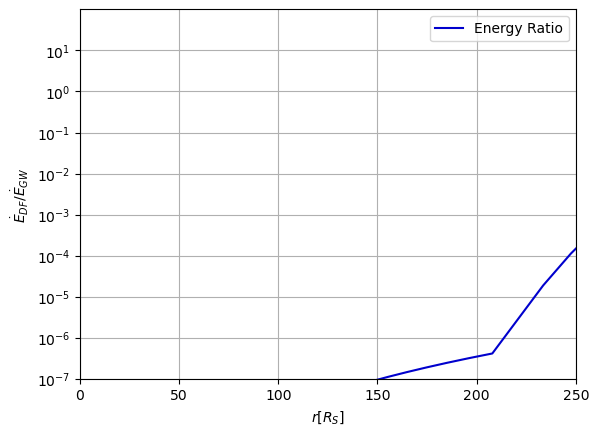

In [69]:

plt.figure()
plt.semilogy(p_evol/6, Eratio, label='Energy Ratio', color='mediumblue')
plt.ylabel('$\dot{E}_{DF}/\dot{E}_{GW}$')
plt.xlabel('$r [R_S]$')
plt.grid()
plt.xlim([0, 250])
plt.ylim([10**(-6), 100])
plt.yticks([10**i for i in range(-7, 2)])
plt.legend()
plt.show()

This plot shows the reason for the difference between the GW from FEW and pydd. FEW is highly relativistic, including many post-Newtonian corrections in the waveform evaluation and the modes from the voice decomposition play a very important role, as opposed to the non-relativistic pydd code. 

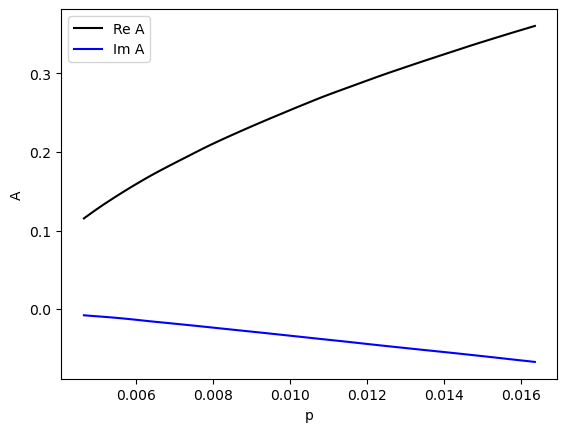

In [70]:
M = 1e5
mu = 1e1
#p0 = 20
p0 = 35.93515813204665
e0 = 0.3
theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc
rho_sp = 220
gamma_sp = 7.0/3
T = 5.0
dt = 10.0

traj = EMRIInspiral(func="SchwarzEccFlux")
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=5.0)


from few.amplitude.romannet import RomanAmplitude
amp = RomanAmplitude(max_init_len=5000)
teuk_modes = amp(p, e)
plt.figure()
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].real, label='Re A', color='k')
plt.plot(p**(-3/2), teuk_modes[:, amp.special_index_map[(2,2,0)]].imag, label='Im A', color='blue')
plt.ylabel('A')
plt.xlabel('p')
plt.legend()
plt.show()

In [71]:
class ApproxSchwarzschildEccentricFluxDF(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            DFTrajectory, # here it is the new trajectory!
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

p0[pc] =  7.178140312382814e-08


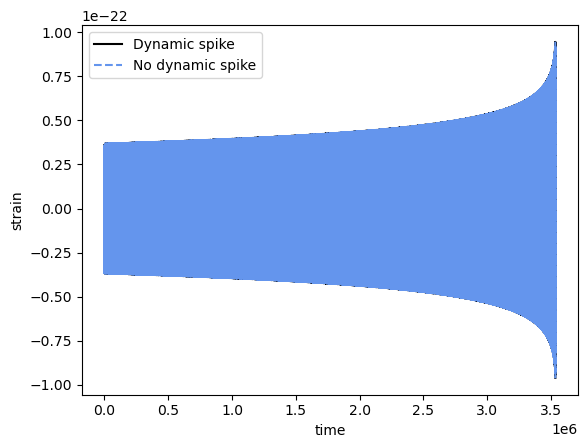

In [72]:
test = ApproxSchwarzschildEccentricFluxDF()

# testing the trajectory
M = 1e5 # M_sun
mu = 1e1 # M_sun
# p0 = 35.93515813204665
# need to either use frequency domain or use fastinterp.
p0 = 15
p0_in_pc = (p0*G_SI*MSUN_SI*M/Power(C_SI, 2))/PC_SI
print('p0[pc] = ', p0_in_pc)
e0 = 0.0

T = 5.0

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)

a = 0.0
xi = 1.0

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

theta = 0
phi = 0
dist = 3.3 # luminosity distance in Gpc

dt = 10.0

specific_modes = (2,2,0)

# waveform with spike
wave_sp = test(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, r_sp, dist=dist, dt=dt, T=T)
time_sp = np.arange(0, len(wave_sp))*dt

rho_sp = 1e-100
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc


# waveform without spike
wave = test(M, mu, p0, e0, theta, phi, gamma_sp, rho_sp, r_sp, dist=dist, dt=dt, T=T)
time = np.arange(0, len(wave))*dt

plt.plot(time_sp, wave_sp.real, color='k', label='Dynamic spike')
plt.plot(time, wave.real, '--', color='cornflowerblue', label='No dynamic spike')
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()

In [73]:
overlap = get_overlap(wave_sp, wave)
print('O = ' ,overlap)

mismatch = get_mismatch(wave_sp, wave)
print('M = ', mismatch)

O =  0.891895997178351
M =  0.108104002821649


In [74]:
for p in sys.path: print(p)

import time, h5py
import corner

from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = DFTrajectory()

from few.utils.utility import cuda_set_device

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from FDutils import *

try:
    import cupy as xp
    # set GPU device
    os.system(f"CUDA_VISIBLE_DEVICES=0")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")

few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean


# fontsize label
fs_lab = 18
# legend
fs_leg = 14
# ticks
fs_ticks = 14
mpl.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "figure.figsize": [default_width, default_width * default_ratio],
  'legend.fontsize': fs_leg,
  'xtick.labelsize': fs_ticks,
  'ytick.labelsize': fs_ticks,
})



/home/ismini/FastEMRIWaveforms/acer_work
/home/ismini/anaconda3/envs/few_env/lib/python310.zip
/home/ismini/anaconda3/envs/few_env/lib/python3.10
/home/ismini/anaconda3/envs/few_env/lib/python3.10/lib-dynload

/home/ismini/anaconda3/envs/few_env/lib/python3.10/site-packages
/home/ismini/FastEMRIWaveforms
/home/ismini/FastEMRIWaveforms/EMRI_FrequencyDomainWaveforms-main/


FileNotFoundError: EMRI_FrequencyDomainWaveforms-main/LISA_Alloc_Sh.txt not found.

In [ ]:
# define the injection parameters
M = 1e5 # M_sun
mu = 1e1 # M_sun

# from Pipa's paper frequency
# initial_f = 3e-3
# initial_p = (3e-3 * (np.pi*M*MTSUN_SI))**(-2/3)
# print(initial_p)
# p0 = 35.93515813204665
# need to either use frequency domain or use fastinterp.

p0 = 15
e0 = 0.0

a = 0.0 # will be ignored in Schwarzschild waveform
x0 = 1.0

qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 3.3 # luminosity distance in Gpc

# initial phases
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0
#theta = 0
#phi = 0

Tobs = 5.0 # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

gamma_sp = 7.0/3
rho_sp = 226
r_sp = (((3-gamma_sp)* 0.2**(3-gamma_sp) * M)/(2 * np.pi * rho_sp))**(1/3) # pc

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
traj_module,
Tobs*0.99,
[M, mu, 0.0, e0, 1.0, gamma_sp, rho_sp, r_sp],
index_of_p=3,
index_of_a=2,
index_of_e=4,
index_of_x=5,
traj_kwargs={},
xtol=2e-12,
rtol=8.881784197001252e-16,
bounds=None,
)


